In [1]:
# import packages
import cftime
import gc
import glob
# import intake
import sys

import cartopy as cy
import cartopy.crs as ccrs
import cmcrameri.cm as ccm
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.stats import norm
import xarray as xr
import geopandas as gpd

from params import savepath, homedir, allnames, datadir
plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 1

states = gpd.read_file('../data/ne_110m_admin_1_states_provinces.shp')

In [71]:
domains = ['d01', 'd02', 'd03', 'd04']
coordsdict = {}
for domain in domains:
    coordsdict[domain] = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_{domain}')

In [2]:
savepath ='/glade/campaign/uwyo/wyom0112/berkeley/'
metapath = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'
domains = ['d02']
gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]


In [59]:
coords = xr.open_dataset(metapath + 'wrfinput_d02')
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]
z = coords['HGT'][0]

In [74]:
tas_ts = pd.read_csv('wrfrun_globalavg_temp.csv', index_col = 0, parse_dates = True)
mask = (tas_ts['year'] >= 1980) & (tas_ts['year'] <= 2000)
baseline = tas_ts[mask].groupby('year').mean(numeric_only = True).mean().values[0]
tas_ts['d_tas'] = tas_ts['tas'] - baseline

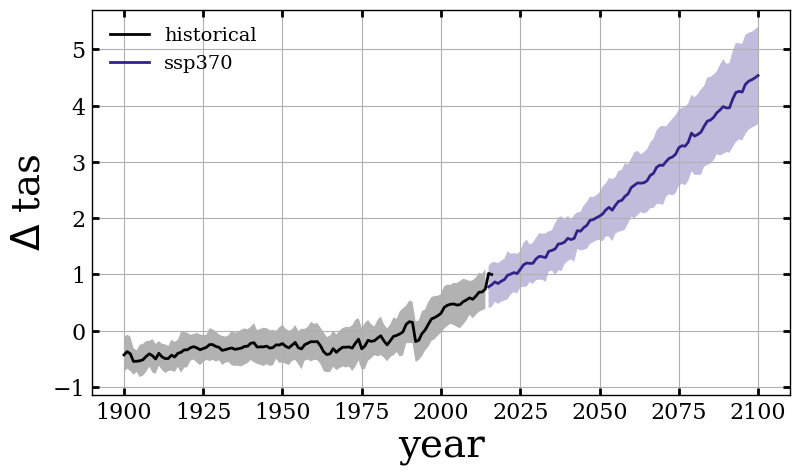

In [75]:
fig, ax = plt.subplots(figsize=(9,5))
    
for experiment_id, data in tas_ts.groupby('experiment_id'):
    grouped = data.groupby('year')['d_tas'].agg(['mean', 'std'])
    ax.plot(grouped.index, grouped['mean'], label=f"{experiment_id}")
    ax.fill_between(grouped.index, grouped['mean'] - grouped['std'], grouped['mean'] + grouped['std'], alpha=0.3)
ax.set_xlabel("year")
ax.set_ylabel(r"$\Delta$ tas")
ax.legend(frameon = False, loc = 'upper left')
ax.grid(True)

plt.show()


In [6]:
gcms_long = ['cesm2_r11i1p1f1_ssp370', 'mpi-esm1-2-lr_r7i1p1f1_ssp370',
       'cnrm-esm2-1_r1i1p1f2_ssp370', 'ec-earth3-veg_r1i1p1f1_ssp370',
       'fgoals-g3_r1i1p1f1_ssp370', 'ukesm1-0-ll_r2i1p1f2_ssp370',
       'canesm5_r1i1p2f1_ssp370', 'access-cm2_r5i1p1f1_ssp370',
       'ec-earth3_r1i1p1f1_ssp370']

map_gcm = {}
for i,rawname in enumerate(tas_ts.source_id.unique()):
    map_gcm[rawname] = {}
    map_gcm[gcms[i]] = {}
    map_gcm[rawname]['raw_to_short'] = gcms[i]
    map_gcm[gcms[i]]['short_to_raw'] = rawname
    map_gcm[gcms[i]]['short_to_long'] = gcms_long[i]
    

In [9]:
## load all the snow
var = 'snow'
domain = 'd02'
bc = 'BC'
snow_monthlyanom = xr.open_dataset(f'{var}_{domain}_{bc}_meananom_annual.nc')


In [7]:
snowdata = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/snow_d02_BC_sorted.nc')
snowmax = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/snowmaxBC.nc').rename({'__xarray_dataarray_variable__':'snow'})

In [42]:
mask = snowmax.mean(dim = 'gcm').sel(time = slice(1981,2000)).sum(dim = 'time')['snow'] > 600

In [8]:
diff_from_baseline = []
per_deg_cc = []
for gcm in gcms:
    tas_gcm = tas_ts[tas_ts.source_id == map_gcm[gcm]['short_to_raw']]
    tmp  = tas_gcm.groupby('year').mean(numeric_only = True)['d_tas']
    df = pd.DataFrame(tmp)
    tas_xr = xr.Dataset(data_vars={'d_tas': ('time', df['d_tas'].values)},
                    coords={'time': df.index.values}).sel(time = slice(1981,2100))
    snow_gcm = snowmax.sel(gcm = map_gcm[gcm]['short_to_long'])
    baseline = snow_gcm.sel(time = slice(1981, 2000)).mean(dim = 'time')
    diff = snow_gcm['snow'] - baseline['snow']
    diff_from_baseline.append(diff)
    per_deg_cc.append(diff / tas_xr['d_tas'])

In [9]:
diffs = xr.concat(diff_from_baseline, dim = 'gcm')
per_deg_cc = xr.concat(per_deg_cc, dim = 'gcm')
mean_perdeg = per_deg_cc.mean(dim = 'gcm')
mean_diff = diffs.mean(dim = 'gcm')

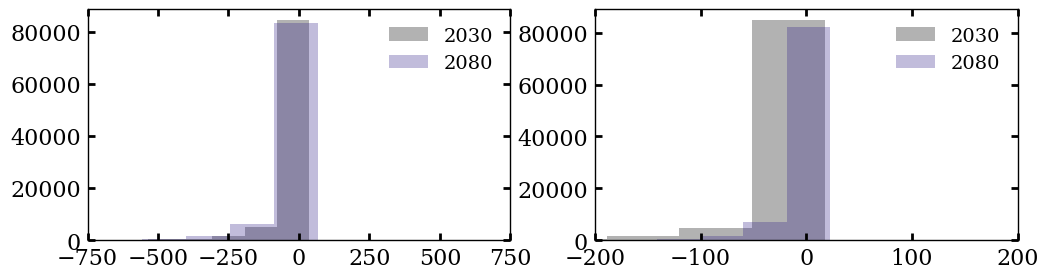

In [16]:
fig,ax = plt.subplots(1,2, figsize = (12,3))
#ax.hist(mean_diff[0].values.flatten(), alpha = 0.3, label = '1980')
ax[0].hist(mean_diff[50].values.flatten(), alpha = 0.3, label = f'{1980+50}')
ax[0].hist(mean_diff[100].values.flatten(), alpha = 0.3, label = f'{1980+100}')
ax[0].set_xlim((-750,750))
ax[0].legend()
ax[1].hist(mean_perdeg[50].values.flatten(), alpha = 0.3, label = f'{1980+50}')
ax[1].hist(mean_perdeg[100].values.flatten(), alpha = 0.3, label = f'{1980+100}')
ax[1].legend()
ax[1].set_xlim((-200,200))
plt.show()

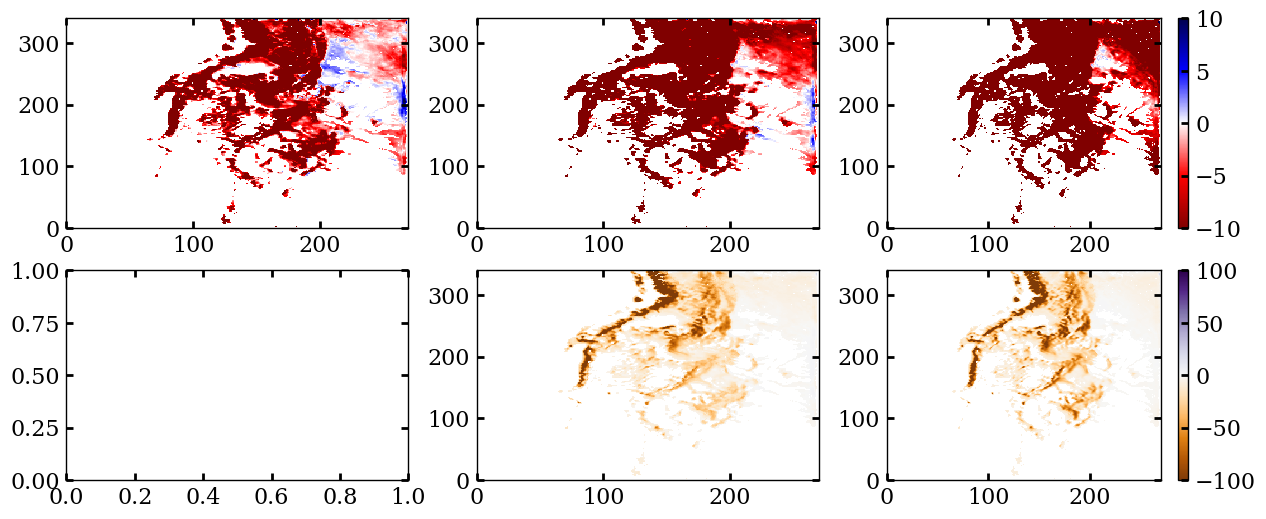

In [43]:
fig,axs = plt.subplots(2,3, figsize = (15,6))
for idx, yr in enumerate([2000, 2030, 2080]):
    plotme = mean_diff.sel(time = slice(yr, yr+20)).mean(dim = 'time').where(mask)
    cb = axs[0,idx].pcolormesh(plotme, cmap = 'seismic_r', vmin = -10, vmax = 10)
    if idx > 0:
        plotme = mean_perdeg.sel(time = slice(yr, yr+10)).mean(dim = 'time').where(mask)
        cb2 = axs[1, idx].pcolormesh(plotme, cmap = 'PuOr', vmin = -100, vmax = 100)
plt.colorbar(cb)
plt.colorbar(cb2)
plt.show()

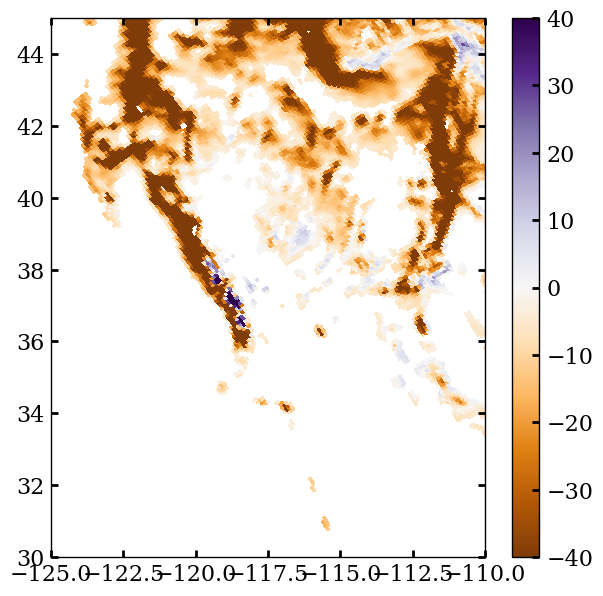

In [61]:
fig,ax = plt.subplots()
cb = ax.pcolormesh(lon, lat, mean_perdeg[55].where(mask), vmin = -40, vmax= 40, cmap = 'PuOr')
plt.colorbar(cb)
ax.set_xlim((-125,-110)) 
ax.set_ylim((30,45))
plt.show()

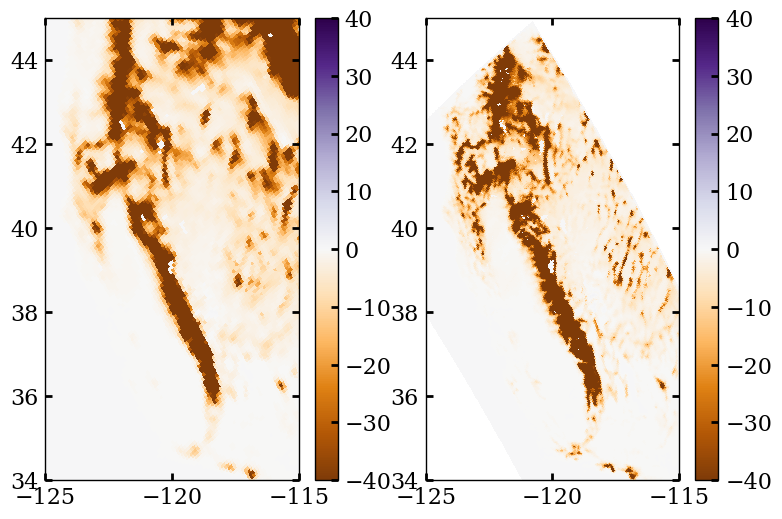

In [123]:
coords3 = coordsdict['d03']
lat3 = coords3['XLAT'][0]
lon3  =coords3['XLONG'][0]
fig,ax = plt.subplots(1,2, figsize = (9,6))
cb = ax[0].pcolormesh(lon, lat, per_deg_cc.sel(gcm = 'ec-earth3-veg_r1i1p1f1_ssp370')[-10:-2].mean(dim = 'time'), vmin = -40, vmax= 40, cmap = 'PuOr')
plt.colorbar(cb)
ax[0].set_xlim((-125,-115)) 
ax[0].set_ylim((34,45))
cb = ax[1].pcolormesh(lon3, lat3, per_deg_cc_ca3[-10:-2].mean(dim = 'time'), vmin = -40, vmax= 40, cmap = 'PuOr')
ax[1].set_xlim((-125,-115)) 
ax[1].set_ylim((34,45))
plt.colorbar(cb)
plt.show()

/glade/scratch/mcowherd/ipykernel_216990/2980012812.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']


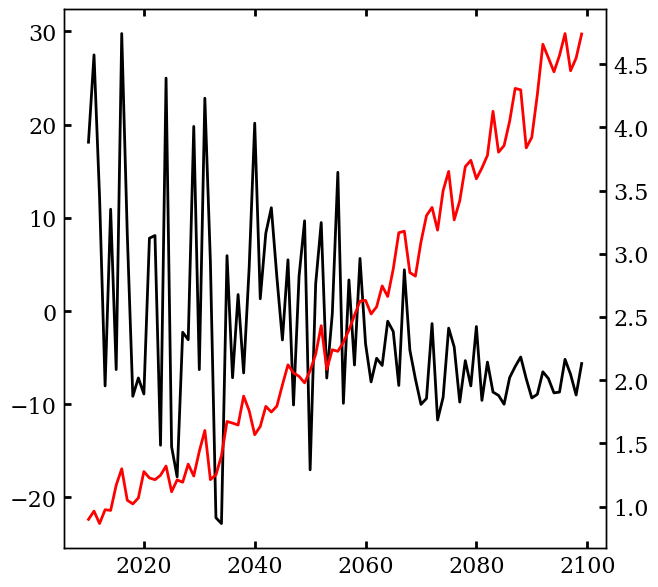

In [155]:
fig,ax = plt.subplots()
ax.plot(range(1980+30, 2100), per_deg_cc_ca3.mean(dim = 'lat2d').mean(dim ='lon2d')[30:])
tmp = tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']
ax.twinx().plot(range(1980+30, 2100),tmp[tmp.index > 1980+30], color = 'red')
plt.show()

/glade/scratch/mcowherd/ipykernel_216990/2390846358.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']


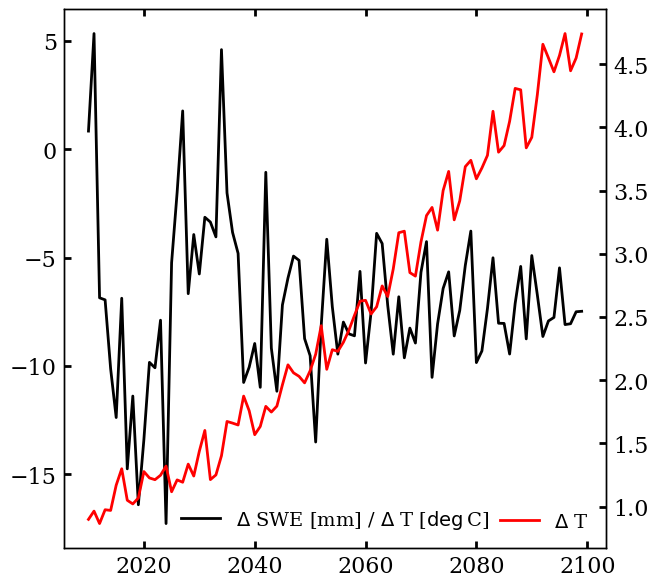

In [165]:
fig,ax = plt.subplots()
ax.plot(range(1980+30, 2100), per_deg_cc.sel(gcm = 'ec-earth3_r1i1p1f1_ssp370').mean(dim = 'lat2d').mean(dim ='lon2d')[30:], 
       label = r'$\Delta$ SWE [mm] / $\Delta$ T [$\deg$C]')
tmp = tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']
ax2 = ax.twinx()
ax2.plot(range(1980+30, 2100),tmp[tmp.index > 1980+30], color = 'red', label = r'$\Delta$ T')
ax.legend(loc = 'lower center')
ax2.legend(loc = 'lower right')
plt.show()

In [161]:
per_deg_cc.sel(gcm = 'ec-earth3-veg_r1i1p1f1_ssp370')

<xarray.DataArray (time: 120, lat2d: 340, lon2d: 270)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.84647613e-01, -3.78783935e-01, -3.98015502e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.68361559e+00, -9.43592803e-01, -4.68950933e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.50078490e+00, -3.86675898e+00, -5.62541741e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.45373955e+01, -9.62121960e+00, -4.24085041e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.10185520e+00,  2.01426108e+00, -1.03963526e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.42928662e-01, -5.07960097e-01, -4.20977732e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.15299590e-01, -5.93008117e-01, -6.23116245e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.63476424e+00, -1.47383531e+00, -7.34169757e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.53551855e+00, -6.01254857e+00, -8.80691570e-02],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.02983054e+00,  1.94320742e+00, -7.56026727e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.48415721e-01,  1.07342801e+00, -1.85338308e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.38977298e-01,  2.78404328e-01, -7.50487252e-02]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.00388507e-01, -6.50401250e-02, -6.83423334e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.89184321e-01, -1.62052847e-01, -8.05224943e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.07162061e+00, -6.64486669e-01, -9.65927583e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.07582449e+00, -5.04299955e+00, -7.28186744e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.47724879e+00, -3.29046411e+00, -1.78513397e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.88834978e-02, -8.72206689e-02, -7.22851255e-02]]])
Coordinates:
  * time     (time) int64 1981 1982 1983 1984 1985 ... 2096 2097 2098 2099 2100
    gcm      <U29 'ec-earth3-veg_r1i1p1f1_ssp370'
Dimensions without coordinates: lat2d, lon2d

In [157]:
per_deg_cc.gcm

<xarray.DataArray 'gcm' (gcm: 9)>
array(['cesm2_r11i1p1f1_ssp370', 'mpi-esm1-2-lr_r7i1p1f1_ssp370',
       'cnrm-esm2-1_r1i1p1f2_ssp370', 'ec-earth3-veg_r1i1p1f1_ssp370',
       'fgoals-g3_r1i1p1f1_ssp370', 'ukesm1-0-ll_r2i1p1f2_ssp370',
       'canesm5_r1i1p2f1_ssp370', 'access-cm2_r5i1p1f1_ssp370',
       'ec-earth3_r1i1p1f1_ssp370'], dtype='<U29')
Coordinates:
  * gcm      (gcm) <U29 'cesm2_r11i1p1f1_ssp370' ... 'ec-earth3_r1i1p1f1_ssp370'

In [136]:
tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']

/glade/scratch/mcowherd/ipykernel_216990/1140721083.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tas_ts[tas_ts.source_id == 'EC-Earth3-Veg'].groupby('year').mean()['d_tas']


year
1900.0   -0.216307
1901.0   -0.284045
1902.0   -0.234747
1903.0   -0.492179
1904.0   -0.595783
            ...   
2096.0    4.568498
2097.0    4.742022
2098.0    4.447513
2099.0    4.548344
2100.0    4.738786
Name: d_tas, Length: 201, dtype: float64

In [144]:
tas_ts

year      source_id experiment_id         tas     d_tas
0     1900.0          CESM2    historical  287.199640 -0.113371
1     1900.0          CESM2        ssp370         NaN       NaN
2     1900.0  MPI-ESM1-2-LR    historical  286.580219 -0.732792
3     1900.0  MPI-ESM1-2-LR        ssp370         NaN       NaN
4     1900.0    CNRM-ESM2-1    historical  286.633665 -0.679346
...      ...            ...           ...         ...       ...
3613  2100.0        CanESM5        ssp370  292.983806  5.670795
3614  2100.0     ACCESS-CM2    historical         NaN       NaN
3615  2100.0     ACCESS-CM2        ssp370  292.625449  5.312438
3616  2100.0      EC-Earth3    historical         NaN       NaN
3617  2100.0      EC-Earth3        ssp370  291.863306  4.550295

[3618 rows x 5 columns]

In [72]:
# perdeg_CA3: 
var = 'snow'
gcm = 'ec-earth3-veg'
domain = 'd03'
bc = 'BC'
ca3_raw = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/{var}_{gcm}_{domain}_{bc}.nc')
ca3_ann = ca3_raw.resample(time = '1AS').max()
ca3_ann['time'] = ca3_ann['time'].dt.year
coords_ca3 = coordsdict['d03']

In [93]:
diff_from_baseline_ca3 = []
per_deg_cc_ca3 = []
tas_gcm = tas_ts[tas_ts.source_id == map_gcm[gcm]['short_to_raw']]
tmp  = tas_gcm.groupby('year').mean(numeric_only = True)['d_tas']
df = pd.DataFrame(tmp)
tas_xr = xr.Dataset(data_vars={'d_tas': ('time', df['d_tas'].values)},
                coords={'time': df.index.values}).sel(time = slice(1981,2100))
baseline = ca3_ann.sel(time = slice(1981, 2000)).mean(dim = 'time')
diff = ca3_ann['snow'] - baseline['snow']
diff_from_baseline_ca3.append(diff)
per_deg_cc_ca3 = diff / tas_xr['d_tas']

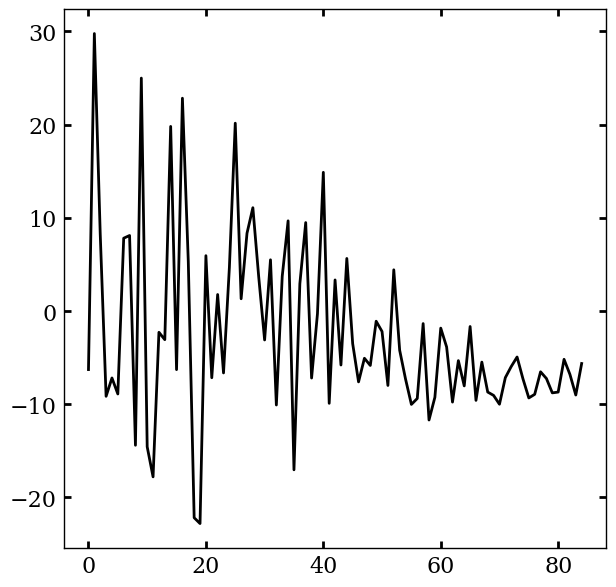

In [95]:
plt.plot(np.nanmean(per_deg_cc_ca3[35:],axis = (1,2)))

/glade/scratch/mcowherd/ipykernel_36662/1520910761.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax.scatter(tas_ts.groupby('year').mean()['d_tas'][1981:],np.nanmean(mean_diff, axis = (1,2)), c = range(1980,2100))


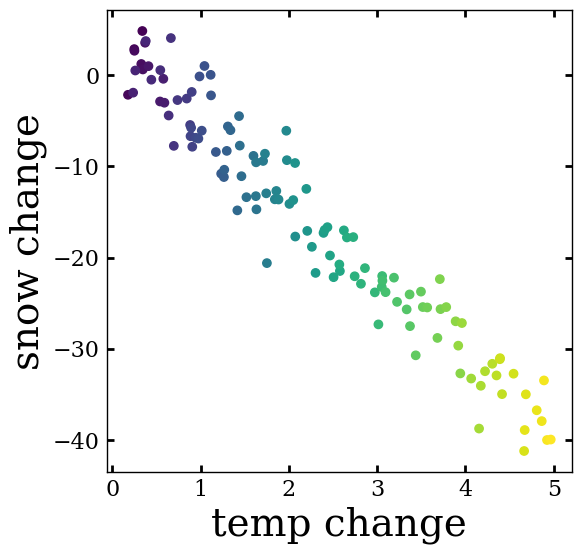

In [47]:
fig,ax = plt.subplots(figsize = (6,6))
ax.scatter(tas_ts.groupby('year').mean()['d_tas'][1981:],np.nanmean(mean_diff, axis = (1,2)), c = range(1980,2100))
ax.set_ylabel('snow change')
ax.set_xlabel('temp change')
plt.show()

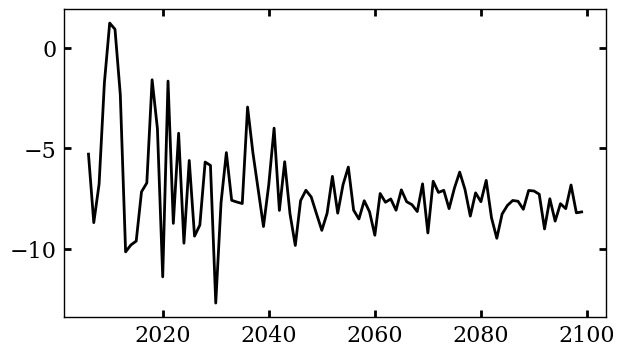

In [17]:
years = range(1980,2100)
fig,ax = plt.subplots(figsize= (7,4))
ax.plot(years[26:],np.nanmean(mean_perdeg[26:], axis = (1,2)))
plt.show()

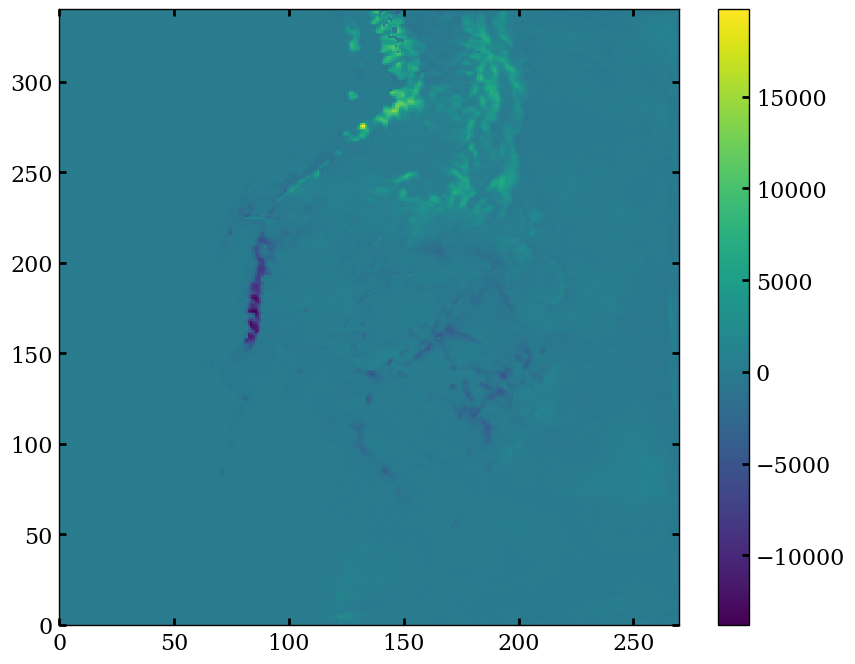

In [124]:
plt.pcolormesh(mean_perdeg.sel(time = slice(1980, 1980+20)).mean(dim = 'time'))
plt.colorbar()

In [10]:
def plot_swei(layout, sddata_dict, metric,domains = ['d02'], nyr = 30,
              CHANGE = False,
              cmap_base = ccm.acton_r,
              cmap_change = ccm.vik,  
              SAVE = False, savename = None):
    
    params = []
    for domain in domains:
        files = glob.glob(savepath + f'categ*{domain}*')
        sweidata = xr.open_dataset(files[0])
        snowdata = xr.open_dataset(glob.glob(savepath + f'snow*{domain}*')[0])
        snowarr = snowdata['snow'].data
        snowmask = np.nansum(snowarr[0:365*10], axis = (0)) > 1500
        coords = xr.open_dataset(f'{metapath}wrfinput_{domain}')
        landmask = coords['XLAND'][0]
        landmask1 = (landmask ==1).data
        X = np.array(coords['XLONG'][0])
        Y = np.array(coords['XLAT'][0])
        params.append({'domain':domain,
                       'sddata':sddata_dict[domain],
                       'snowmask':snowmask, 
                       'landmask1':landmask1,
                       'X':X, 'Y':Y})
        gcms = gcms_list[domain]

    stats_fc = [[[],[],[]],
        [[],[],[]],
        [[],[],[]],
        [[],[],[]]]
    savedata = [[[],[],[]],
            [[],[],[]],
            [[],[],[]],
            [[],[],[]]]
    
    labels = [[['Warm', f'{layout[0][0][1]}-{layout[0][0][1] + nyr}' ],
               [None, f'{layout[0][1][1]}-{layout[0][1][1] + nyr}'],[None, f'{layout[0][2][1]}-{layout[0][2][1] + nyr}']],
            [['Warm and Dry', None],[None,None],[None,None]],
            [['Dry', None],[None,None],[None,None]],
            [['All', None],[None,None],[None,None]]]
    fig = plt.figure(figsize = (12,17))

    c = 1
    for i in range(4):
        for j in range(3):
            ax = fig.add_subplot(4,3,c, projection = proj_flat)
            c+=1
            drt = layout[i][j][0]
            yrs = layout[i][j][1]
            for param in params:
                sddata = param['sddata']
                snowmask = param['snowmask']
                landmask1 = param['landmask1']
                X = param['X']
                Y = param['Y']
                          
                data = sddata[drt]
                datasets = list(data.values())
                if metric == 'Frequency':
                    concatenated_dataset = xr.concat(datasets, dim='gcm')
                    vmin_base = 0 
                    vmax_base = 1

                if metric == 'Severity':
                    tmp = []
                    for gcm in gcms:
                        tmp.append(sddata['swei'][gcm].where(data[gcm]))
                    concatenated_dataset = xr.concat(tmp, dim = 'gcm')['swei']
                    vmin_base = -np.e
                    vmax_base = -0.8
                ds_mean = concatenated_dataset.sum(dim = 'gcm')


                data2plot = np.nanmean(ds_mean[yrs-1980:yrs-1980+nyr],axis = 0)

                data2save = data2plot
                cmap = cmap_base
                num_steps = 6
                new_cmap = colors.LinearSegmentedColormap.from_list('truncated_cmap',
                                                                    cmap(np.linspace(0.0, 1.0, num_steps)))
                vmin = 0 
                vmax = 1


                if CHANGE and j > 0:
                    data2plot = np.nanmean(ds_mean[yrs-1980:yrs-1980+nyr],axis = 0) - np.nanmean(ds_mean[0:nyr],axis = 0)

                data2plot[~landmask1] = np.nan
                data2plot[~snowmask] = np.nan

                if j <= 1 or ~CHANGE :
                    cb1 = ax.pcolormesh(X,Y,data2plot, cmap = new_cmap, vmin = vmin_base, vmax = vmax_base)
                    bounds1 = np.linspace(vmin_base, vmax_base, num_steps+1)
                    norm1 = colors.BoundaryNorm(bounds1, new_cmap.N)
                if CHANGE and j > 1:
                    cmap = cmap_change
                    vmin = -1
                    vmax = 1
                    num_steps = 9
                    new_cmap = colors.LinearSegmentedColormap.from_list(
                    'truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))
                    cb0 = ax.pcolormesh(X,Y,data2plot, cmap = new_cmap, vmin = vmin, vmax = vmax)
                    bounds0 = np.linspace(vmin, vmax, num_steps+1)
                    norm0 = colors.BoundaryNorm(bounds0, new_cmap.N)
                savedata[i][j] = data2save
                stats_fc[i][j] = np.nanmean(data2plot)
                ## end
                
            states.boundary.plot(ax=ax, linewidth = 1)
            ax.set_xlim((-125,-100))
            ax.set_ylim((30,50))
            ## top labales
            ax.set_title(labels[i][j][1])
                    
    fig.tight_layout()
    
    ## side labels
    fig.text(0, 0.15, 'All', va='center', ha='left', rotation=90)
    fig.text(0, 0.37, 'Dry', va='center', ha='left', rotation=90)
    fig.text(0, 0.6, 'Warm and Dry', va='center', ha='left', rotation=90)
    fig.text(0, 0.85, 'Warm', va='center', ha='left', rotation=90)

    ## color bars
    cax0 = plt.axes([0.38, -0.03, .575, 0.03])
    cax1 = plt.axes([0.1, -0.03, .18, 0.03])
    cbar0 = fig.colorbar(cb0, cax = cax0, orientation = 'horizontal', fraction = 0.15, boundaries = bounds0)
    cbar0.set_label(label='Change [-]',size=30)
    cbar0.set_ticks([-1, 0, 1])
    cbar1 = fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15, boundaries = bounds1)
    cbar1.set_label(label=f'{metric} [-]',size=30)
    cbar1.set_ticks([vmin_base, vmax_base])

    plt.show()    
    if SAVE:
        fig.savefig(f'../figures/{savename}.jpg')

    return savedata, stats_fc




In [4]:
## prep a nice dictionary with the conditions included in a format that is nice
'''
domains = ['d02']
variables = ['snow', 't2', 'prec']
gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]


variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',]
      

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian', 'proleptic_gregorian',]

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370']

'''
domains = ['d01', 'd02',['d03', 'd04']]
domain = domains[0]

files = glob.glob(savepath + f'categs*{domain}*')
sweidata = xr.open_dataset(files[0])
snowdata = xr.open_dataset(glob.glob(savepath + 'snow*')[0])
snowarr = snowdata['snow'].data
snowmask = np.nansum(snowarr[0:365*10], axis = (0)) > 1500
coords = xr.open_dataset(f'{metapath}wrfinput_{domain}')
landmask = coords['XLAND'][0]
landmask1 = (landmask ==1).data
lon2d = np.array(coords['XLONG'][0])
lat2d = np.array(coords['XLAT'][0])


variables = ['snow', 't2', 'prec']
variants = ['r1i1p1f1',]
calendar = ['proleptic_gregorian']
ssps = ['ssp370']

gcms_list = {'d01':  ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1','fgoals-g3','ukesm1-0-ll',
        'canesm5','ec-earth3-veg',],
        'd02': ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',],
        'd03': ['ec-earth3-veg'],
        'd04': ['ec-earth3-veg']}

def make_sddata(domain):
    gcms = gcms_list[domain]
    sddata = {}
    for dr_t in ['all','dry','warm','warmdry','swei']:
        sddata[dr_t] = {}
        for gcm in gcms:
            sddata[dr_t][gcm] = {}

    for gcm in gcms:
        sddata[gcm] = {}
        swei = xr.open_dataset(f'{savepath}swei_max_snow_{gcm}_{domain}_BC.nc') #swei_datasets_maxsnw[f'{model}_{exp}']
        categ = xr.open_dataset(f'{savepath}categs_snow_{gcm}_{domain}_BC.nc')
        swei_cond = categ['swei_cond']
        pr_cond = categ['pr_cond']
        tas_cond = categ['tas_cond']
        sddata['all'][gcm] = swei_cond
        sddata['dry'][gcm] = swei_cond & pr_cond & ~tas_cond
        sddata['warm'][gcm] = swei_cond & ~pr_cond & tas_cond
        sddata['warmdry'][gcm] = swei_cond & pr_cond & tas_cond
        sddata['swei'][gcm] = swei
    return sddata



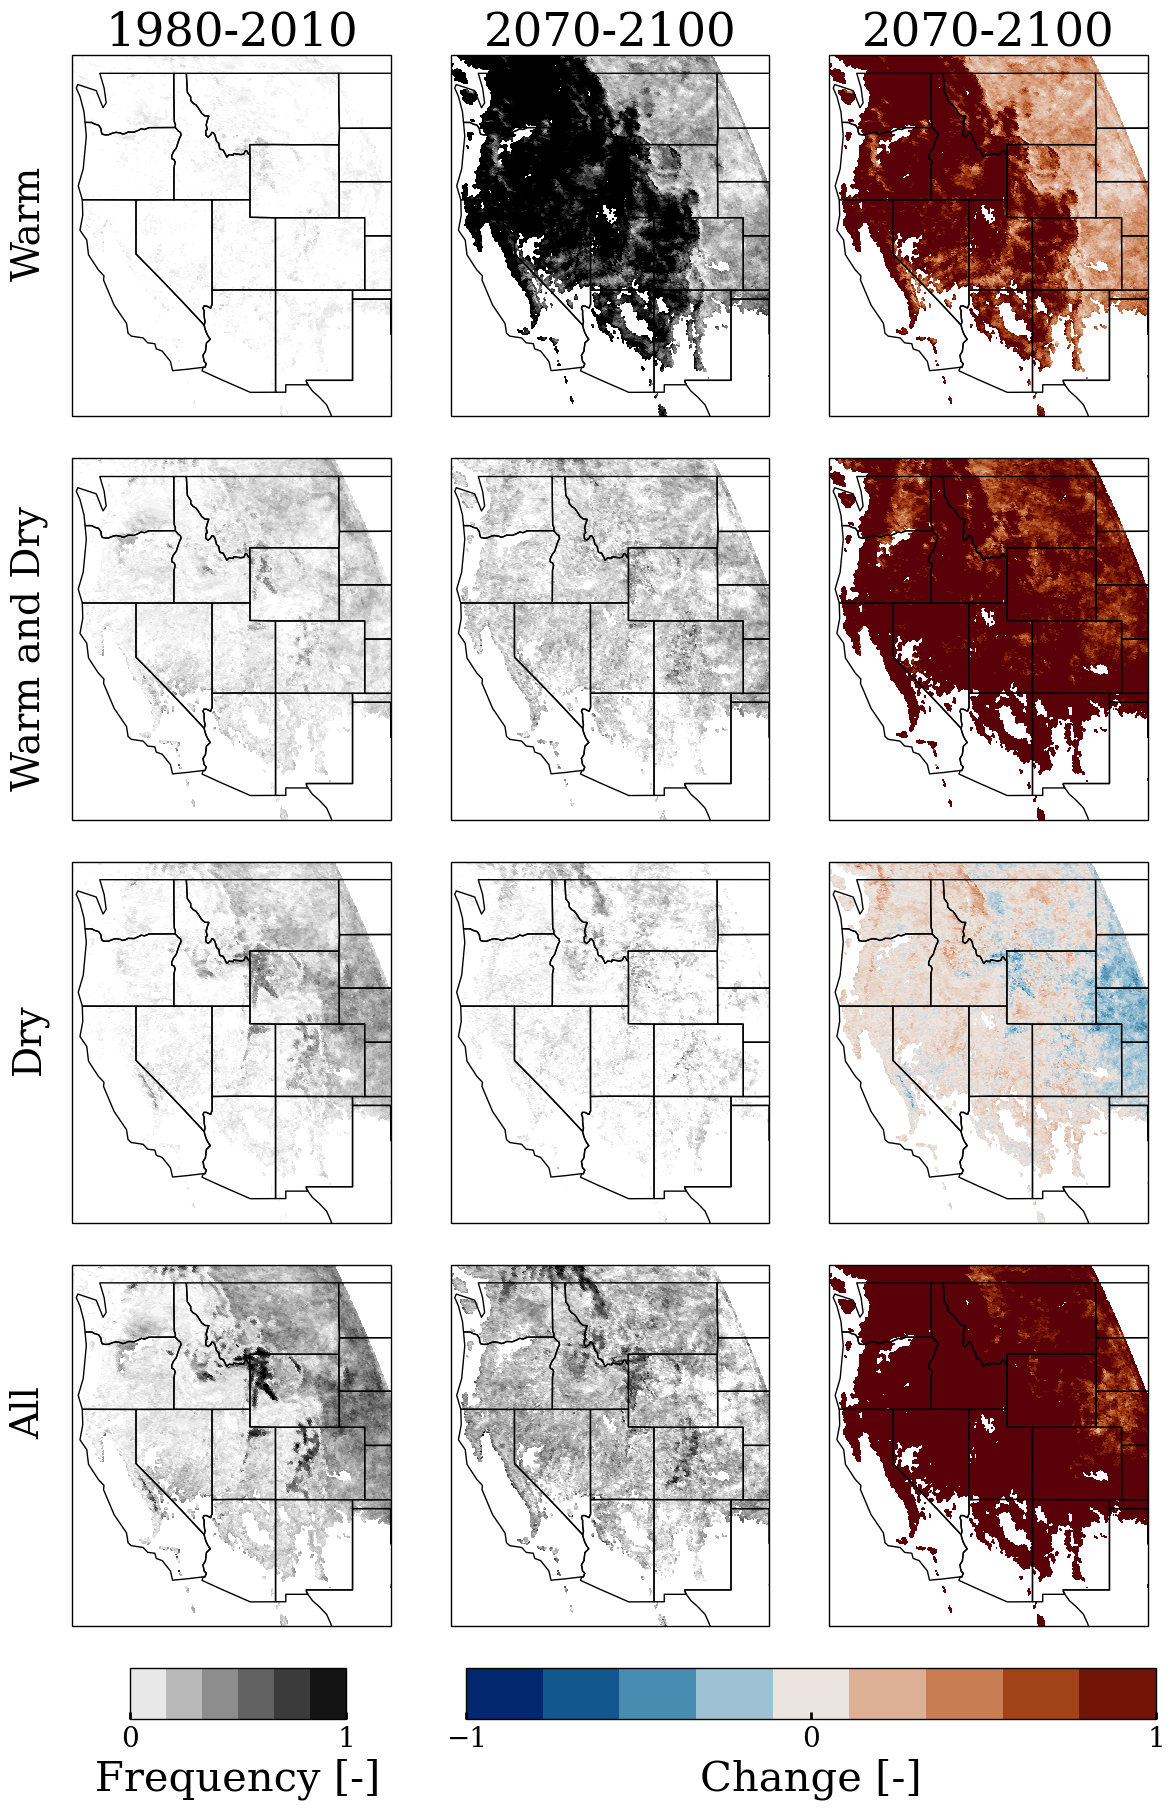

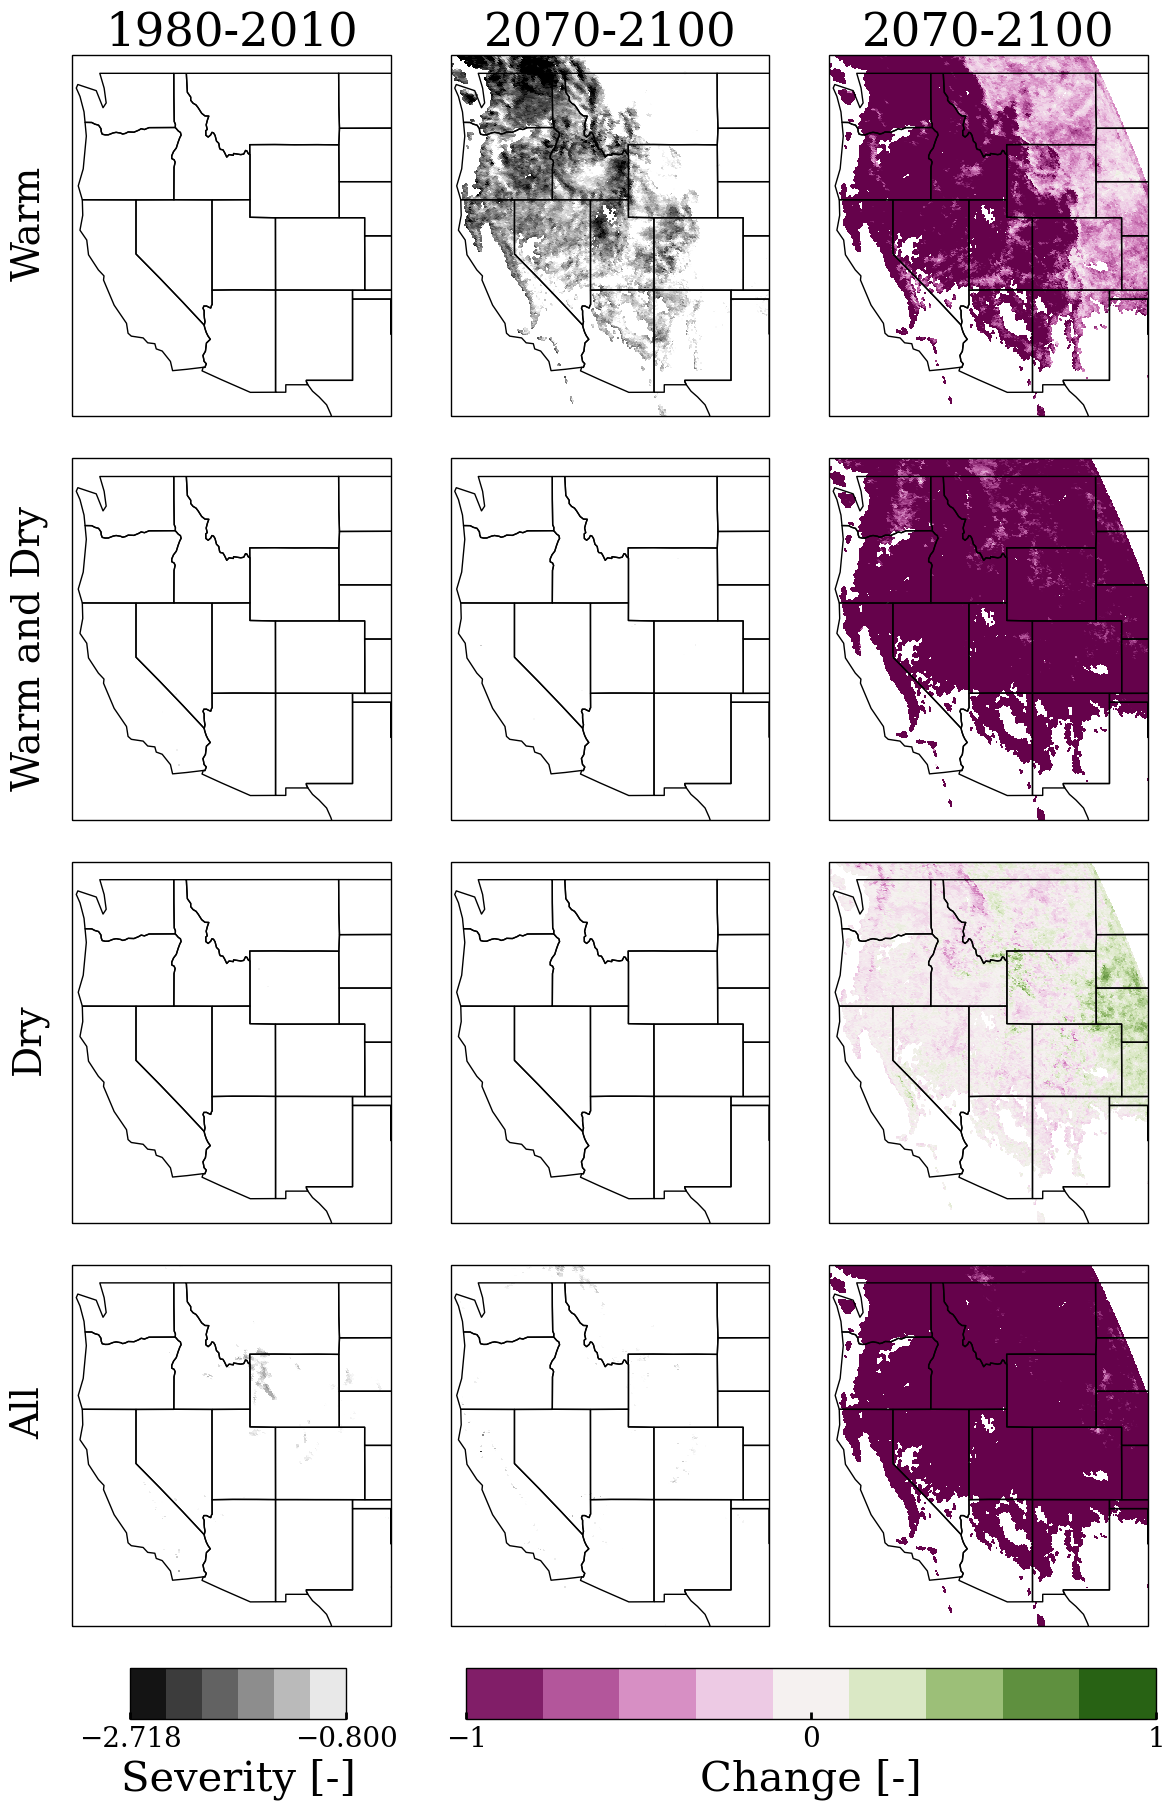

In [11]:
from matplotlib import colors
layout = [[['warm', 1980],['warm', 2070], ['warm', 2070]],
          [['warmdry', 1980],[ 'warmdry', 2020], [ 'warmdry', 2070]],
          [['dry', 1980],[ 'dry', 2020], ['dry', 2070]],
          [[ 'all', 1980],[ 'all', 2020], ['all', 2070]]]

domains = ['d01', 'd02','d03','d04']
params = {'Frequency': [ccm.grayC, ccm.vik],
          'Severity': [ccm.grayC_r, ccm.bam]}
proj_flat = ccrs.PlateCarree()
stats_dict = {}
for domain in [['d02']]:
    sddata_dict = {}
    for d in domain:
        sddata_dict[d] = make_sddata(d)
    if domain[0] == 'd02': res = '9km'
    elif domain[0] == 'd03': res = '3km'
    elif domain[0] == 'd01': res = '45km'
    stats_dict[res] ={}
    for name, param in params.items():
        nyr = 30
        CHANGE = True
        cmap_base = param[0]
        cmap_change = param[1]
        SAVE = True
        savename = f'{name}_{len(domain)}_{nyr}yr_map'
        stats_dict[res][name] = {}
        savedata, stats_fc = plot_swei(layout, sddata_dict, domains = domain, nyr = nyr,
                                       metric = name,
                                      CHANGE = CHANGE,
                                      cmap_base = cmap_base,
                                      cmap_change = cmap_change,  
                                      SAVE = SAVE, savename = savename)
        stats_dict[res][name]['savedata'] = savedata
        stats_dict[res][name]['stats_fc'] = stats_fc


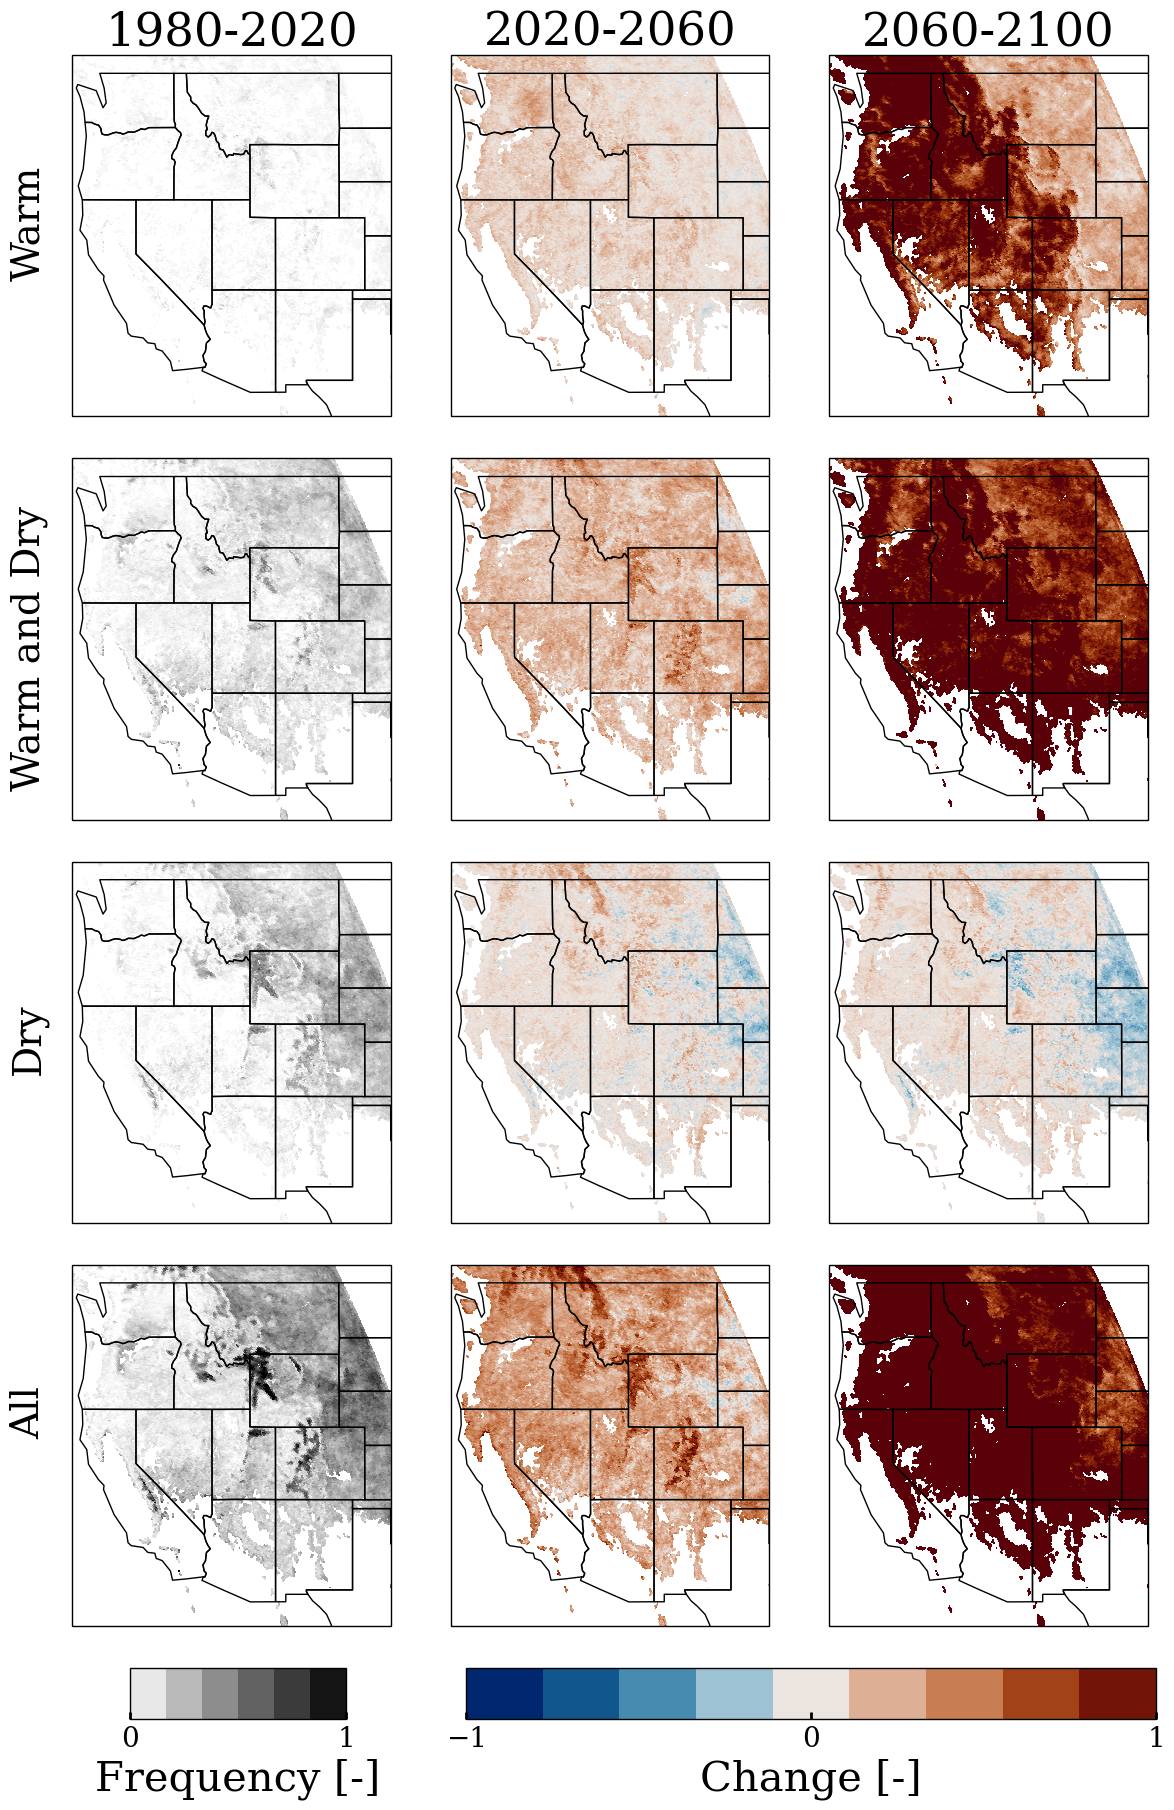

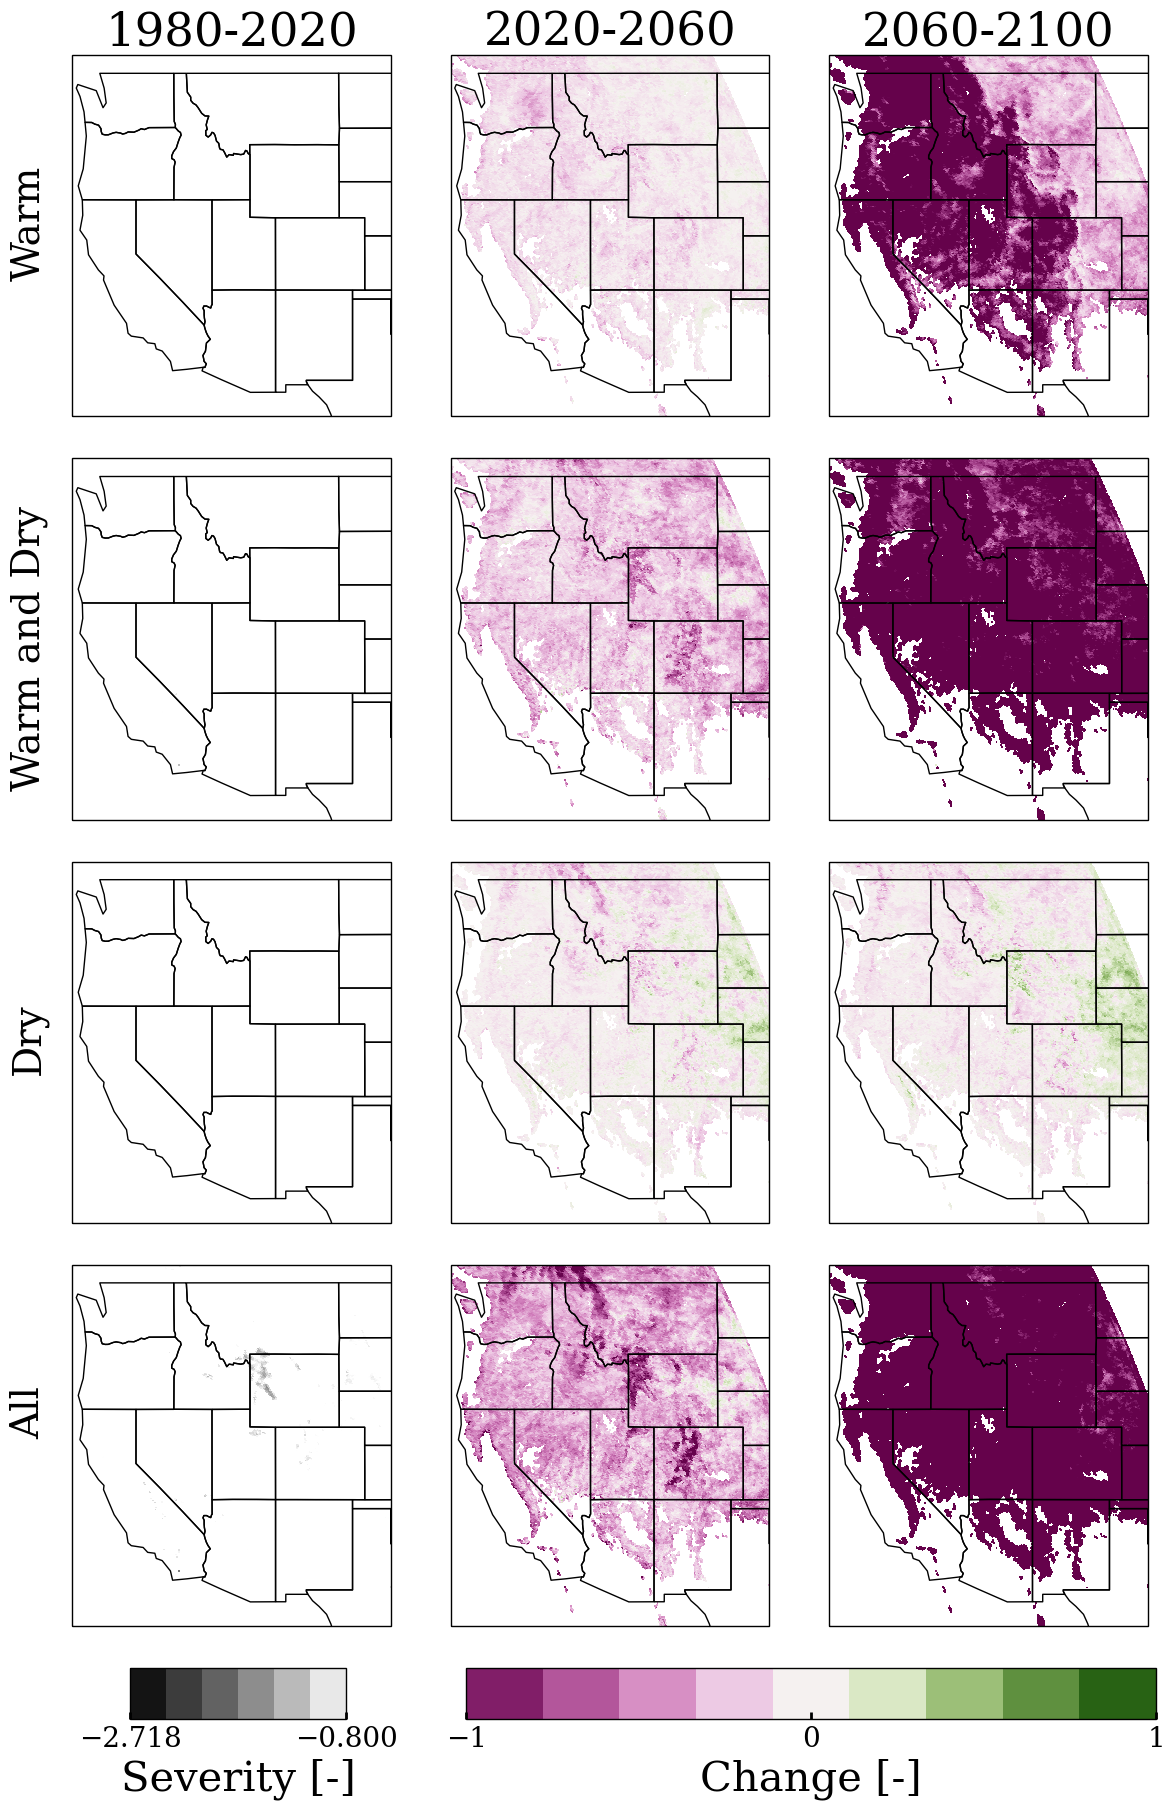

In [5]:
from matplotlib import colors
layout = [[['warm', 1980],['warm', 2020], ['warm', 2060]],
          [['warmdry', 1980],[ 'warmdry', 2020], [ 'warmdry', 2060]],
          [['dry', 1980],[ 'dry', 2020], ['dry', 2060]],
          [[ 'all', 1980],[ 'all', 2020], ['all', 2060]]]

domains = ['d01', 'd02','d03','d04']
params = {'Frequency': [ccm.grayC, ccm.vik],
          'Severity': [ccm.grayC_r, ccm.bam]}
proj_flat = ccrs.PlateCarree()
stats_dict = {}
for domain in [['d02']]:# ['d01'],['d02'],['d03','d04']]:
    sddata_dict = {}
    for d in domain:
        sddata_dict[d] = make_sddata(d)
    if domain[0] == 'd02': res = '9km'
    elif domain[0] == 'd03': res = '3km'
    elif domain[0] == 'd01': res = '45km'
    stats_dict[res] ={}
    for name, param in params.items():
        nyr = 40
        CHANGE = True
        cmap_base = param[0]
        cmap_change = param[1]
        SAVE = True
        savename = f'{name}_{len(domain)}_{nyr}yr_map'
        stats_dict[res][name] = {}
        savedata, stats_fc = plot_swei(layout, sddata_dict, domains = domain, nyr = nyr,
                                       metric = name,
                                      CHANGE = CHANGE,
                                      cmap_base = cmap_base,
                                      cmap_change = cmap_change,  
                                      SAVE = SAVE, savename = savename)
        stats_dict[res][name]['savedata'] = savedata
        stats_dict[res][name]['stats_fc'] = stats_fc


In [6]:
## to do: cut out the regions where the d03 and d04 
## domains overlap the d02 domain to be able to compare
## stefan has some code to do this probably
## outcome predictions: similar general trends (same model) but ability to pick up on local patterns
## look at bc vs nbc predictions -- albedo feedbacks?

In [6]:
def plot_ts (domain):
    data2plot = make_sddata(domain)
    
    snowdata = xr.open_dataset(glob.glob(savepath + f'snow*{domain}*_BC*')[0])
    snowarr = snowdata['snow'].data
    snowmask = np.nansum(snowarr[0:365*10], axis = (0)) > 1500
    coords = xr.open_dataset(f'{metapath}wrfinput_{domain}')
    landmask = coords['XLAND'][0]
    landmask1 = (landmask ==1).data

    '''   for name, data in data2plot.items():
        for name2, data2 in data.items():
            if name == 'swei': tmp = data2['swei'].data
            else: tmp = data2.data
            tmp[:,~landmask1] = np.nan
            tmp[:,~snowmask] = np.nan
            data2plot[name][name2] = tmp
            '''
    gcms = data2plot['all'].keys()
    
    categories = {
        'dry': None,
        'warmdry': None,
        'warm': None,}
    for name in categories.keys():
        tmp = []
        for gcm in gcms:
            tmp.append(data2plot[name][gcm].where(landmask1).where(snowmask))
        ds_concat = np.array(tmp)
        categories[name] = np.nanmean(ds_concat, axis = (0,2,3))
    wet = [] 
    lownorm = []
    highnorm = []
    for gcm in gcms:
        lownorm.append(((data2plot['swei'][gcm]['swei'] > -0.8) & (data2plot['swei'][gcm]['swei'] < 0 )).where(landmask1).where(snowmask))
        highnorm.append(((data2plot['swei'][gcm]['swei'] > 0) & (data2plot['swei'][gcm]['swei'] < 0.9 )).where(landmask1).where(snowmask))
        wet.append((data2plot['swei'][gcm]['swei'] > 0.8).where(landmask1).where(snowmask))
    wet2 =  np.nanmean(np.array(wet), axis = (0,2,3))

    categories['lownorm'] = np.nanmean(np.array(lownorm), axis = (0,2,3))#  1 - categories['dry'] - categories['warm'] - categories['warmdry'] - wet2
    categories['highnorm'] = np.nanmean(np.array(highnorm), axis = (0,2,3))
    categories['wet'] =wet2
    
    for name, data in categories.items():
        data[34] = np.nan

    years = range(1980,2101)
    clist = ['gold', 'coral', 'darkred', 'darkgray', 'lightgray', 'mediumpurple']
    fig,ax = plt.subplots(figsize = (15,5))
    ax.stackplot(years,categories.values(), labels = categories.keys(), colors = clist)
    ax.set_ylim((0,1))
    ax.set_xlim((1981,2099))
    ax.legend(loc = 'upper right', bbox_to_anchor = (1.2,1))
    ax.set_ylabel('proportion of area')
    ax.set_xlabel('year')
    plt.show()

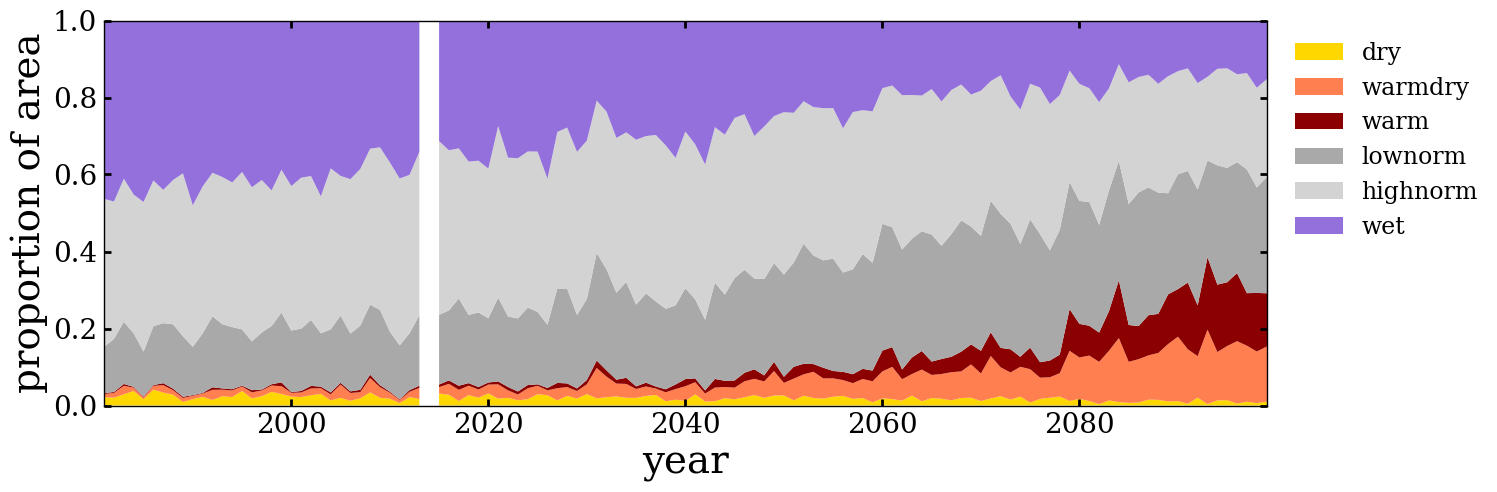

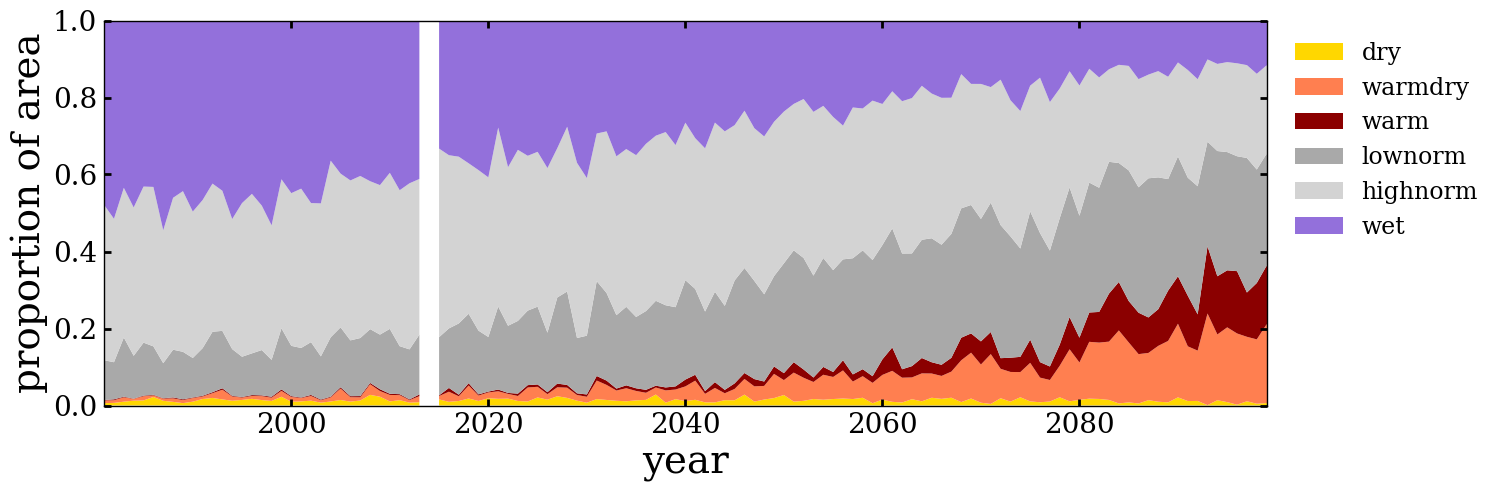

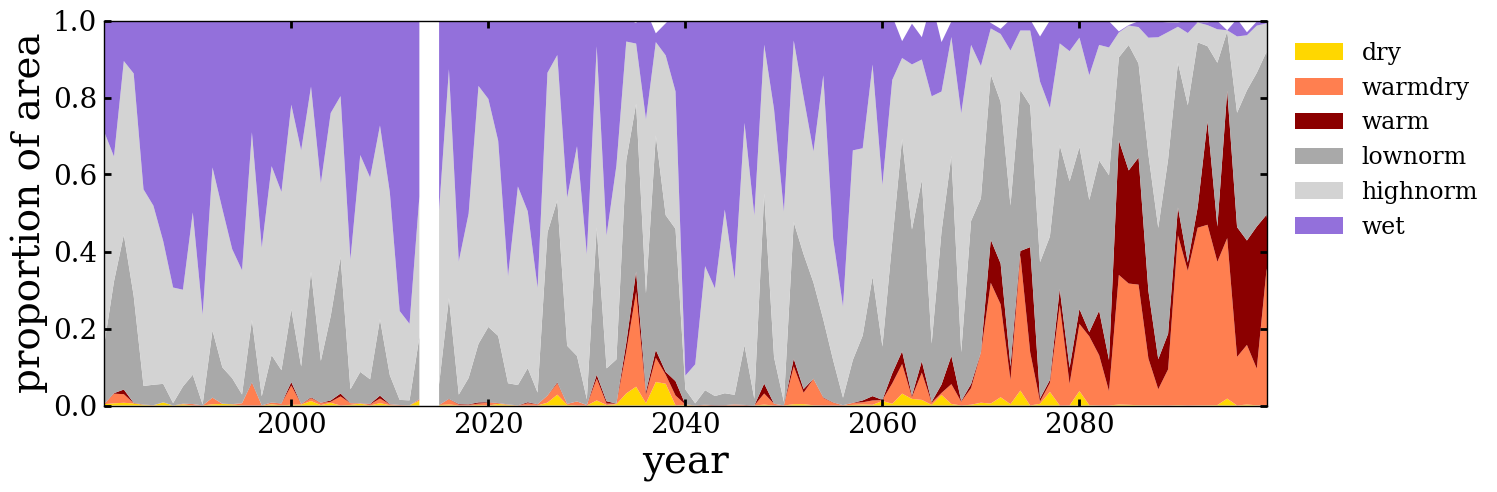

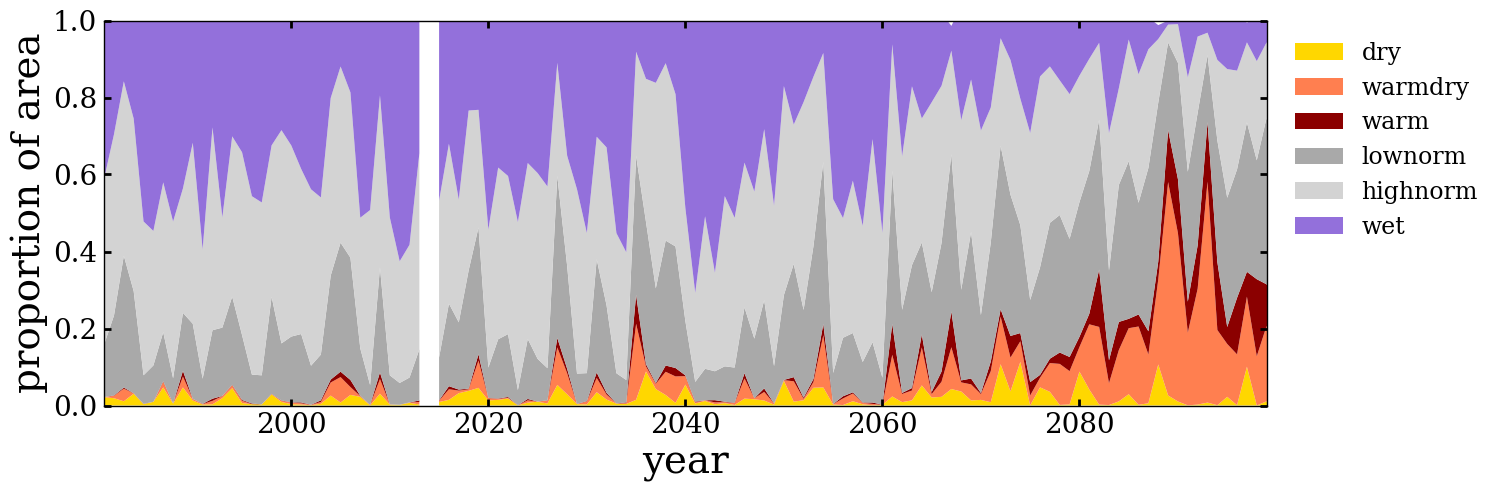

In [7]:
plot_ts('d01')
plot_ts('d02')
plot_ts('d03')
plot_ts('d04')


In [9]:
def rescale_lists(categories):
    rescaled_categories = {}

    # Calculate the total for each year across all categories
    totals = [sum(year) for year in zip(*categories.values())]

    # Iterate over each category in the dictionary
    for category, values in categories.items():
        rescaled_values = [value / total for value, total in zip(values, totals)]
        rescaled_categories[category] = rescaled_values

    return rescaled_categories

def plot_type(domain):
    data2plot = make_sddata(domain)
    
    snowdata = xr.open_dataset(glob.glob(savepath + f'snow*{domain}*')[0])
    snowarr = snowdata['snow'].data
    snowmask = np.nansum(snowarr[0:365*10], axis = (0)) > 1500
    coords = xr.open_dataset(f'{metapath}wrfinput_{domain}')
    landmask = coords['XLAND'][0]
    landmask1 = (landmask ==1).data

    gcms = data2plot['all'].keys()
    
    categories = {
        'dry': None,
        'warmdry': None,
        'warm': None,}
    for name in categories.keys():
        tmp = []
        for gcm in gcms:
            tmp.append(data2plot[name][gcm].where(landmask1).where(snowmask))
        ds_concat = np.array(tmp)
        categories[name] = np.nanmean(ds_concat, axis = (0,2,3))
    
    for name, data in categories.items():
        data[34] = np.nan
        
    
    out_categ = rescale_lists(categories)
    
    tmp = []
    for gcm in gcms:
        tmp.append(data2plot['all'][gcm].where(landmask1).where(snowmask))
    ds_concat = np.array(tmp)
    total_freq = np.nanmean(ds_concat, axis = (0,2,3))

    years = range(1980,2101)
    clist = ['gold', 'coral', 'darkred']
    fig,ax = plt.subplots(figsize = (15,5))
    ax.stackplot(years,out_categ.values(), labels = out_categ.keys(), colors = clist)
    ax.plot(years, total_freq, color = 'white')
    ax.set_ylim((0,1))
    ax.set_xlim((1981,2099))
    ax.legend(loc = 'upper right', bbox_to_anchor = (1.2,1))
    ax.set_ylabel('proportion of droughts')
    ax.set_xlabel('year')
    plt.show()

/glade/scratch/mcowherd/ipykernel_183187/1642150849.py:9: RuntimeWarning: invalid value encountered in double_scalars
  rescaled_values = [value / total for value, total in zip(values, totals)]


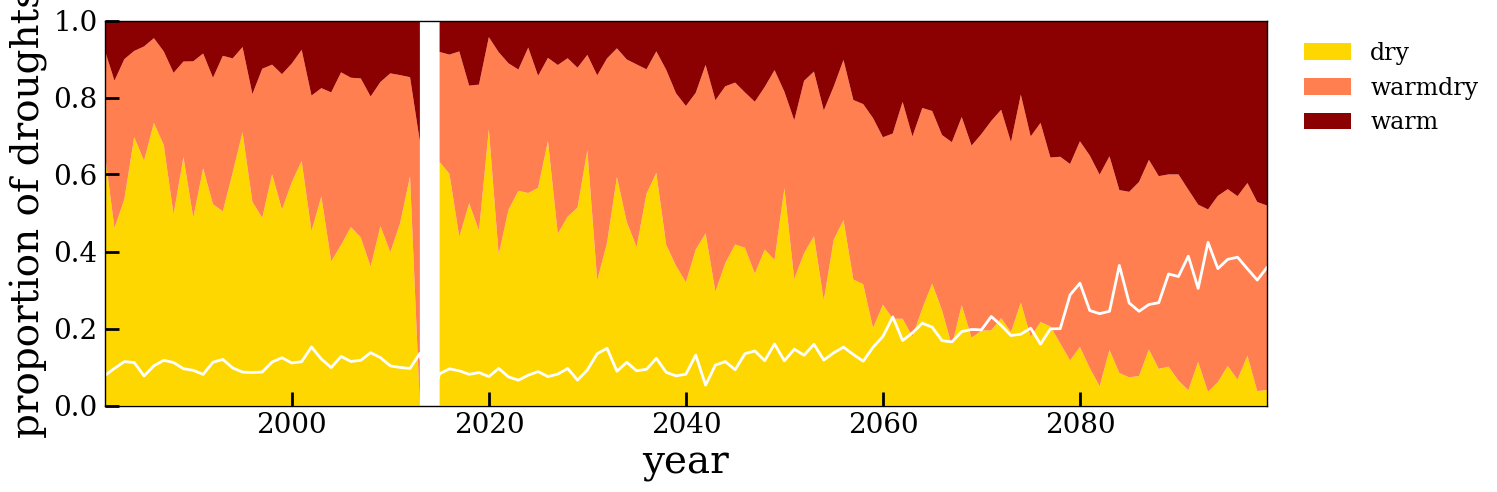

/glade/scratch/mcowherd/ipykernel_183187/1642150849.py:9: RuntimeWarning: invalid value encountered in double_scalars
  rescaled_values = [value / total for value, total in zip(values, totals)]


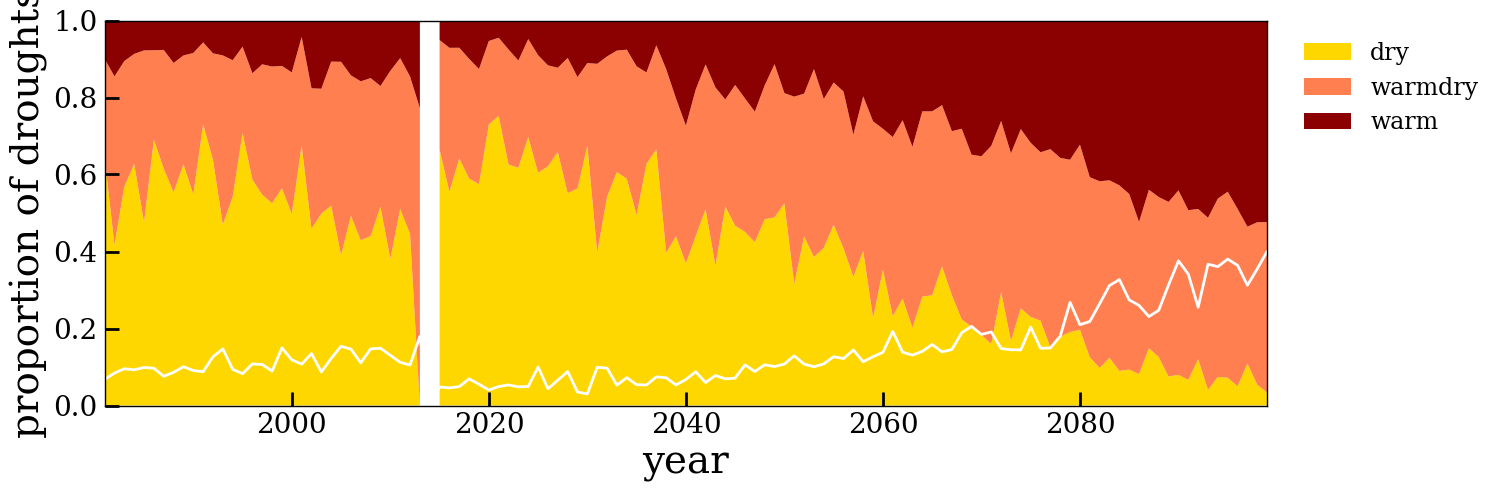

/glade/scratch/mcowherd/ipykernel_183187/1642150849.py:9: RuntimeWarning: invalid value encountered in double_scalars
  rescaled_values = [value / total for value, total in zip(values, totals)]


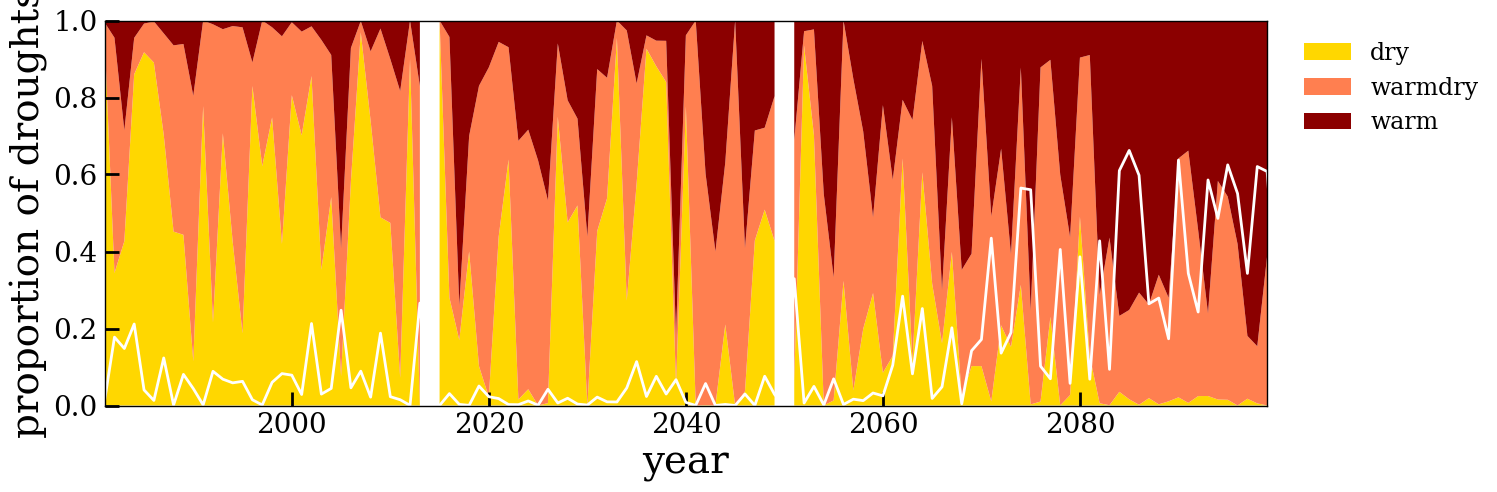

/glade/scratch/mcowherd/ipykernel_183187/1642150849.py:9: RuntimeWarning: invalid value encountered in double_scalars
  rescaled_values = [value / total for value, total in zip(values, totals)]


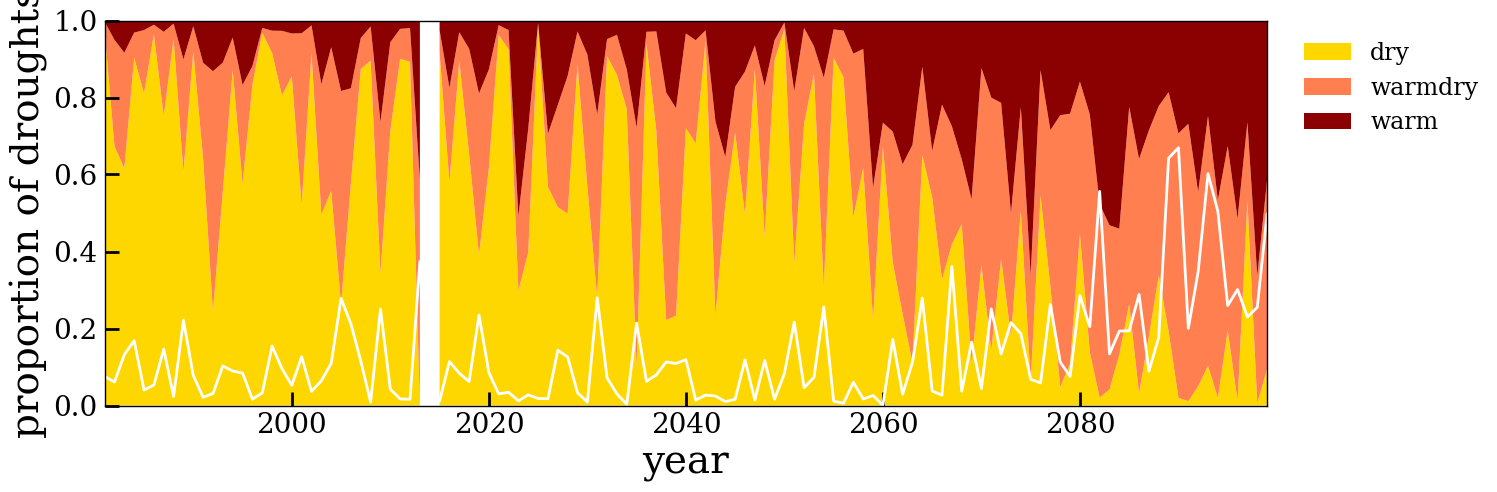

In [10]:
plot_type('d01')
plot_type('d02')
plot_type('d03')
plot_type('d04')